<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [298]:
pip install sklearn-lvq

In [299]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math

In [300]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [301]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,dot_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('horas', color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('radiación solar', color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)              
    plt.show()

In [302]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 7',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

   YEAR  MONTH  DAY  0  1  2  3    4    5    6  ...        17   18   19   20  \
0  2018      1    1  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
1  2018      1    2  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
2  2018      1    3  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
3  2018      1    4  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
4  2018      1    5  0  0  0  0  0.0  0.0  0.0  ...  0.033333  0.0  0.0  0.0   

   21  22  23         SUMA        dSUMA   ddSUMA  
0   0   0   0  1942.683333 -1613.866667  1773.45  
1   0   0   0   328.816667 -1613.866667  1773.45  
2   0   0   0   488.400000   159.583333  1773.45  
3   0   0   0  1801.133333  1312.733333  1153.15  
4   0   0   0  1174.666667  -626.466667 -1939.20  

[5 rows x 30 columns]


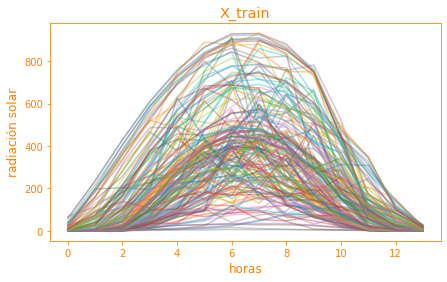

In [303]:
df = pd.read_csv('rg1_horas.csv')
df = df[(df.MONTH==11)|(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)|(df.MONTH==3)|(df.MONTH==4)]
print(df.head())
horas_ = ['5','6','7','8','9','10','11','12','13','14','15','16','17','18']
X = df[horas_].to_numpy()
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X  = sc.fit_transform(X)
#y  = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=.5)#

print_serie(X_train,'X_train',False)
#print_serie(X_test,'X_test')

# **K-means**


[13  9  3  3 10  0  2 12  5  8  3  2  9  2  2 11 11  4  5 12 10 12  6  6
  1  0  0 11  9  4  9  1 11 11  8  0  0  4  5  3  0 10  5  4 11  9 11  6
 10  8  0  0 11  0  6 11 11  2 14  5  9 14  0  0  0  0 11  2  0  0  2  2
  1  0 14  0 10 11  1  9  5  5  2  9 11  5  5  1  3  7  2  0 10  3  6  1
 11 14  5  0  3  9  9  3  2  2  8  3  9 12  5  0  9 11 15 10  2  3 15  9
  1 11 10  0  2 11 12 10  0  4  0 11  6 12  5  9  1 11  5 11  2 11  4 11
  5 12 10 11 14 11 11  1  2  9  3  5 11  5  0  2  0  2  9 10 14  2  0 10
  9  2 13 11  0  0  3  8  9  2  5  0]


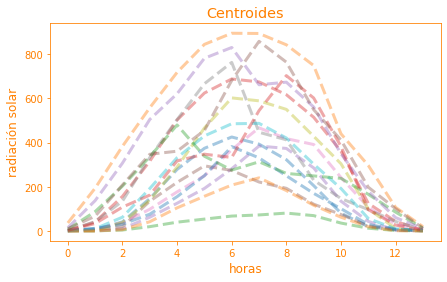

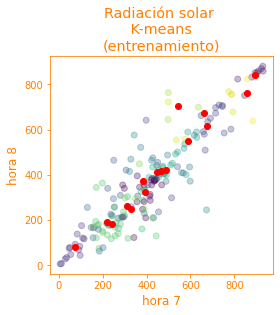

In [304]:
n_clusters = 16

k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans  
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_pred = k_means.predict(X_test)
print(y_pred)
print_serie(centers_,'Centroides',True)
scatterplot(X_train[:,7],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


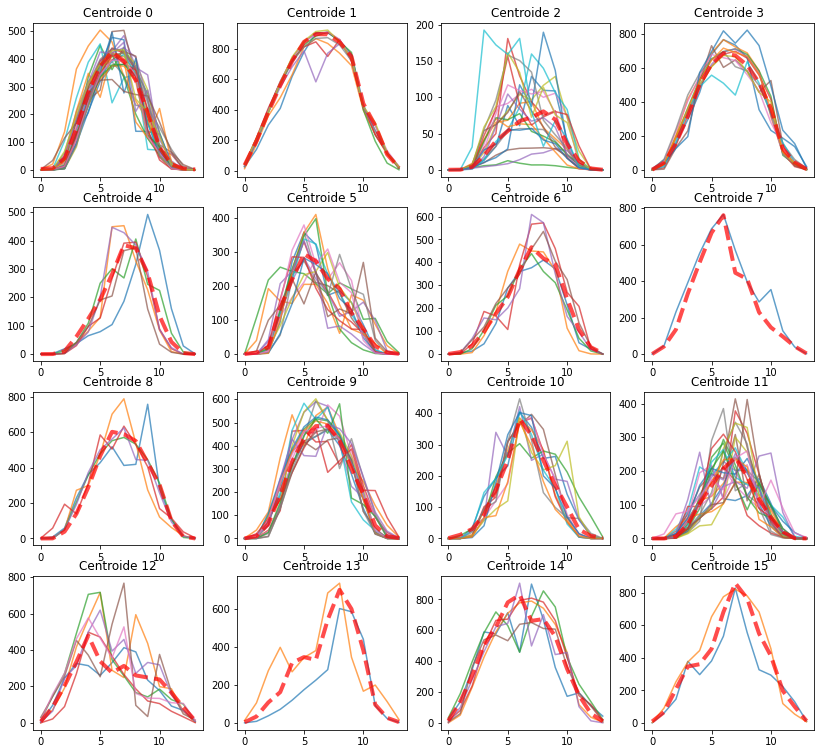

In [315]:
cat = np.unique(y_pred)
print(cat)
n = math.ceil(pow(n_clusters, 0.5))
fig, axs = plt.subplots(n, n, figsize=(14,13))
row=0
col=0

for c in cat:
    j = 0
    for g in y_pred:    
        if c == g:
            axs[row,col].plot(X_test[j],alpha=0.7)
            axs[row,col].set_title('Centroide '+str(c))
        j = j + 1
    axs[row, col].plot(centers_[c],alpha=0.7,color='red', linestyle='dashed', linewidth =4)
    col = col+1
    if col==n:
        col=0
        row=row+1  
plt.show()   

# **LVQ**

In [305]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

print('GLVQ:')
glvq = GlvqModel(prototypes_per_class=5, initial_prototypes=None)
glvq.fit(X_train,labels)
glvq_pred = glvq.predict(X_test)
print(glvq_pred)
print('classification accuracy:', glvq.score(X_test, glvq_pred))
plt.show()

GLVQ:
[ 6  9  3  3  4  0  2 12  5  8  3  2  9  2  2  2 11  6  5 12 10 12  6  6
  1  0  0 11  9  4  9  1  4 11  8  0  9  4  5  3  0  4  5  4 11  9 11  4
 10  8  0  0  5  0  6 11 11  2 14  5  9 14  0  0  0  0 11  2  0  0  2  2
  1  0 14  0 10  2  1  9  5 11  2  9 11  5  5  1  3  7  2  0 10  3  6  1
 11 14  5  0  3  9  9  3  2  2  8  3  9  0  5  0  9  5  9 10  2  3  3  9
  1 11 10  0  2 11  9 10 12  4  0 11  6  9  5  9  1 11  5 11  2 11 10 11
  5 12 10 11 14 11 11  1  2  6  3  5 11  5  0  2  0  2  9  0  3  2  0 10
  9  5  9 11  0  0  3  8  9  2  5  0]
classification accuracy: 1.0


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]


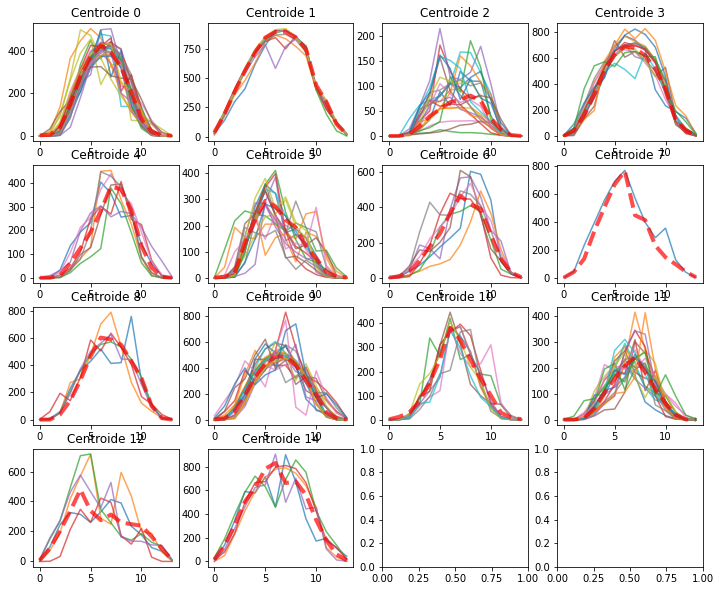

In [306]:
cat = np.unique(glvq_pred)
print(cat)
n = math.ceil(pow(n_clusters, 0.5))
fig, axs = plt.subplots(n, n, figsize=(12,10))
row=0
col=0

for c in cat:
    j = 0
    for g in glvq_pred:    
        if c == g:
            axs[row,col].plot(X_test[j],alpha=0.7)
            axs[row,col].set_title('Centroide '+str(c))
        j = j + 1
    axs[row, col].plot(centers_[c],alpha=0.7,color='red', linestyle='dashed', linewidth =4)
    col = col+1
    if col==n:
        col=0
        row=row+1  
plt.show()    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]


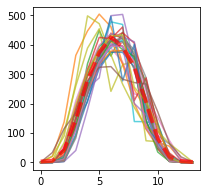

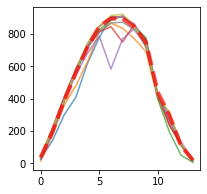

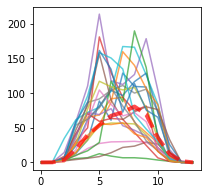

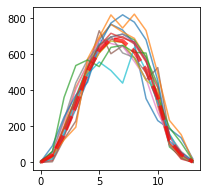

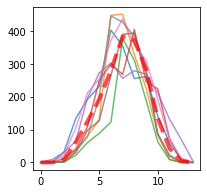

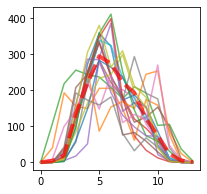

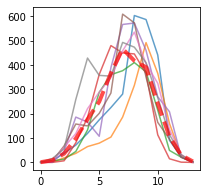

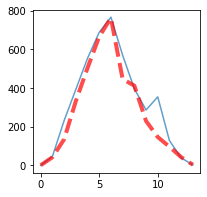

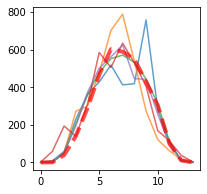

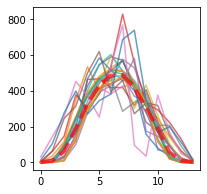

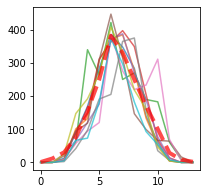

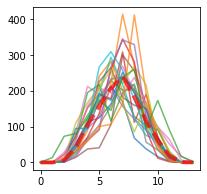

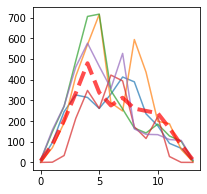

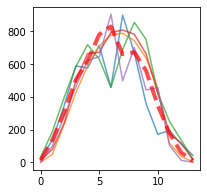

In [307]:
cat = np.unique(glvq_pred)
print(cat)

for c in cat:
    plt.figure(figsize=(3, 3))
    j = 0
    for g in glvq_pred:    
        if c == g:
            plt.plot(X_test[j],alpha=0.7)            
        j = j + 1
    plt.plot(centers_[c],alpha=0.7,color='red', linestyle='dashed', linewidth =4)
    plt.show()  

# **GaussianMixture**

In [308]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# fit a Gaussian Mixture Model with two components
gm = GaussianMixture(n_components=n_clusters, init_params='kmeans',covariance_type='diag') #full, tied, diag, spherical
gm.fit(X_train)

print(gm.predict(X_test))
gm_pred = gm.predict(X_test)
print('classification accuracy:', gm.score(X_test, gm_pred))


[13  7  8  3  0  2  2 14  2  3  3  2  5 11  2  0  2 13 14  3  2 14 13  2
  6 14  7  2  7  2 13  6  2  2 13  0  7  2 14  3  2 14  2  2  0  7  2 13
  2  7  2  0  0  2 13  2  0 11  6  0  7  8  0  2  2  0  2 11  7  7  2 11
  6  2  6  0  0  0  1  7  0  2  2  7  2  2  2  6  3  3  2  7  2  3 13  1
  2  8  0  2  3  7  7  3  2 11  3  3  7 14  2  2  7  2 14  0  2  3  8  7
  1  2  0  2  2  2 14  2  0  2  2  2 13 14  2 14  1  2  2  2  2 13  2  2
  0 14  0  2  3  2  2  1 11  3  8  0  2 13  2  2  0  2  7  2 10  2 14  2
  7  0 14 14  2  2  3  7  7 11  0  0]
classification accuracy: -55.695655583032


[ 0  1  2  3  5  6  7  8 10 11 13 14]


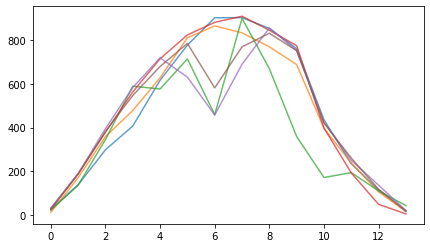

In [309]:
uni = np.unique(gm_pred)
print(uni)
plt.figure(figsize=(7, 4))
j=0
for i in gm_pred:
    if i==6:
      plt.plot(X_test[j],alpha=0.7)
    j = j + 1
plt.show()

# **KNN**

In [310]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

[[  0.         207.85144274 285.89353541 293.66797346 296.37919126]
 [  0.         184.21953163 193.48932502 205.0604965  207.82374678]
 [  0.         127.18218782 132.89639239 150.3403389  152.74318955]
 [  0.          83.97625651 113.34912389 144.61125861 151.56013932]
 [  0.         107.64878716 116.91218096 127.09019222 140.58940115]
 [  0.         204.87403789 221.35004456 243.53395216 276.79804962]
 [  0.          76.90382878  78.8225592   85.90436213  87.30394543]
 [  0.          93.83417855 152.43362126 179.62285175 198.86480612]
 [  0.          13.25147788  27.54182679  71.7700823   85.90436213]
 [  0.          83.97625651 111.47331645 119.35777451 134.764386  ]
 [  0.         308.09800031 310.84783259 329.82955999 339.10638858]
 [  0.         200.70594428 209.76775641 245.05819377 245.20869394]
 [  0.          59.66517693 109.36705018 119.84019218 131.88223279]
 [  0.         186.29371599 260.78965346 264.06181779 270.53161347]
 [  0.          11.53743906  55.53197277  66.294

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [311]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, labels)
knn_pred = knn.predict(X_test)
print(knn_pred)
#print(knn.predict_proba(X_test))
knn.score(X_test,knn_pred)

[ 6  0  3  3  4  0  2 12  5  8  3  2  9  2  2  2 11  4  5 12 10 12  6  6
  1  0  0 11  9  4  9  1 11 11  8  0  0  4  5  3  0  4  5  4 11  9 11  4
 10  8  0  0  5  0  6 11  5  2  3  5  9  3  0  0  0  0 11  2  0  0  2  2
  1  0  1  0  0  2  1  9  5  5  2  9 11  5 11  1  3  3  2  0 10  3  6  1
 11 14  5  0  3  9  9  3  2  2  3  3  9  0 11  0  9  5  9 10  2  3  3  9
  1 11 10  0  2  5  9 10 10  4  0 11  6  9  5  6  1 11  5 11  2  5 11 11
  5 12  0 11  3 10 11  1  2  6  3  5 11  5  0  2  0 11  9  0  3  2  0 10
  9  5  3 11  0  0  3  8  9  2  5  0]


1.0

[ 0  1  2  3  4  5  6  8  9 10 11 12 14]


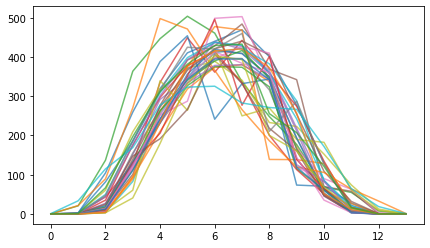

In [312]:
uni = np.unique(knn_pred)
print(uni)
plt.figure(figsize=(7, 4))
j=0
for i in knn_pred:
    if i==0:
      plt.plot(X_test[j],alpha=0.7)
    j = j + 1
plt.show()

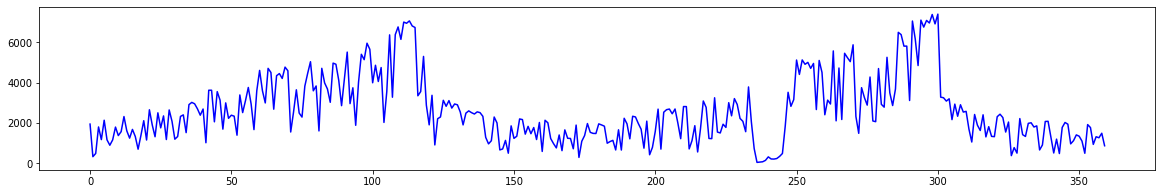

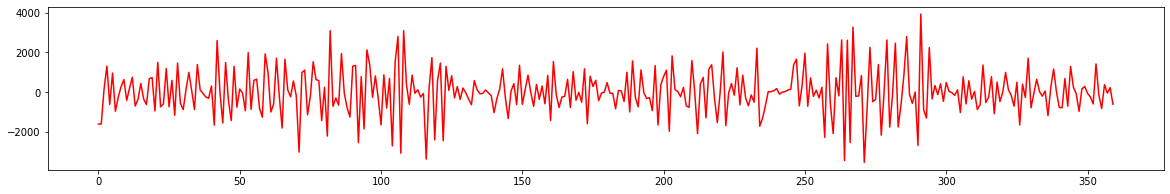

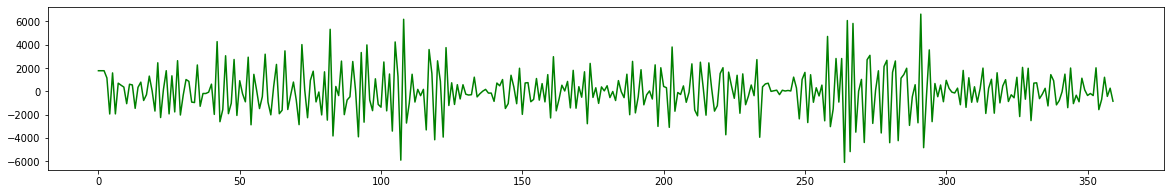

<Figure size 1440x216 with 0 Axes>

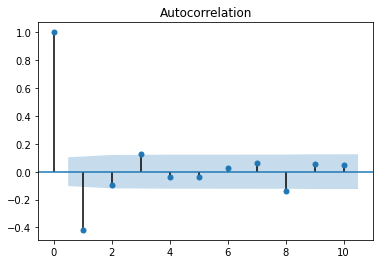

<Figure size 1440x216 with 0 Axes>

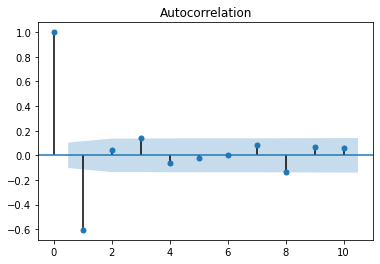

In [313]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=1,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=1,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=1,color='green')
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()